# tile llc model run and distribute parcels runs


To do:

- [X] changer l'arborescence
- [X] ajouter l'interpolation de traceurs/niveau de la mer/profondeur
- [ ] ajouter la sortie de la vitesse?
- [X] ajouter des particules au fil de la simulation
- [ ] devrait-on essayer de compiler avec le compilateur intel?



https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_interpolation.ipynb

https://nbviewer.jupyter.org/github/OceanParcels/parcels/blob/master/parcels/examples/tutorial_Argofloats.ipynb

https://www.reddit.com/r/learnpython/comments/4rj7ie/how_to_find_the_difference_between_all_pairs_of/
https://towardsdatascience.com/finding-distant-pairs-in-python-with-pandas-fa02df50d14b


Messages/Questions pour Sylvie:

- `parcels.py` - Pourquoi les tiles 23 et 3 et le drifter 3000002.0 sont-ils traités de manière particulière?
- ajout de particules au fil des simulations, comment gérer des nouveaux identifiants de particules qui ne vont pas rentrer en conflit avec les précédents
- dans la boucle de run: pourquoi les steps supérieurs à 1000 sont ils considérés différemment?
- pourquoi les numéros de trajectoire ne sont pas entier?
- peut-on directement sortir les vitesses?
- peut-on ajouter la profondeur?
- ligne 683, 733: `del pset` ne sert à rien je pense, à vérifier

- l'arborescence a changé: `/run`, `/tiling`, `/parquets`, `/diagnostics`

In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.3362920.datarmor0/parcels-55081/libparcels_random_07432bb1-6532-45df-8835-2cc904c34cbd.so


In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

single = False

if single:
    cluster = LocalCluster()
else:
    cluster = PBSCluster(processes=5, cores=5, walltime='48:00:00')
    w = cluster.scale(jobs=5)

client = Client(cluster)
client

Client Scheduler: tcp://10.148.0.254:34453 Dashboard: http://10.148.0.254:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## setup directories and run parameters

In [3]:
#root_dir = '/home1/scratch/aponte/parcels/'
root_dir = '/home1/datawork/aponte/parcels/'
#root_dir = '/home1/datawork/slgentil/parcels/'

# 5x5 tiles dij=100 T=365 5jobs x 5workers
#run_name = 'global_T365j_dt1j_dij50'
#run_name = 'debug'
run_name = 'global_extra_T365j_dt1j_dij50'

In [4]:
# simulation parameters

T = 360 # length of the total run [days]
#T = 360 # length of the total run [days]
#T = 20 # ** debug
#dt_windows = 5 # time window
dt_windows = 2 # ** debug, 5j devrait être plus approprié je pense
dt_stepping = 1 # hours
dt_outputs = 1 # hours

init_dij = 50 # initial position subsampling compared to llc grid

overwrite = False

In [5]:
# create run directory tree
dirs = pa.create_dir_tree(root_dir, run_name, overwrite=overwrite)

Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/tiling
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/parquets
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/diagnostics


---

## load llc data

In [6]:
# load llc data
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
grd = ut.load_grd()[['XC', 'YC', 'XG', 'YG']]
ds = xr.merge([ds, grd])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(88,), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

---

## create tiles

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [7]:
#create_tiles = False
create_tiles = overwrite

if create_tiles:
    # create tiling
    tl = pa.tiler(ds=grd.reset_coords(), factor=(5, 5), overlap=(250, 250))
    # store tiler
    tl.store(dirs["tiling"])
else:
    tl = pa.tiler(tile_dir=dirs["tiling"])

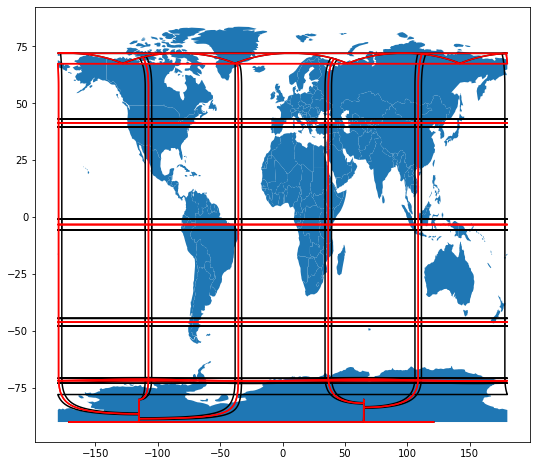

In [8]:
crs = tl.crs_wgs84

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
new_world = world.to_crs(crs)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
new_world.plot(ax=ax)
for t in tl.G['tiles']:
    t.to_crs(crs).boundary.plot(ax=ax, color="black")
for b in tl.G['boundaries']:
    b.to_crs(crs).boundary.plot(ax=ax, color="red")
#ax.set_axis_off()
plt.show()

--- 

## loop over time windows (main loop)

** we will probably need a restart mechanism the loop from a given time, it may be as simple as changing `np.arange(0,T, dt_windows)` into `np.arange(t_restart,T, dt_windows)`

** we may need to manually clear memory (for example if llc dataset has been persisted within tile_store_llc)


In [9]:
tl.create_tile_run_tree(dirs["run"], overwrite=overwrite)
#tl.create_tile_run_tree(dirs["run"], overwrite=True)

Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_000
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_001
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_002
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_003
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_004
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_005
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_006
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_007
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_008
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_009
Not overwriting /home1/datawork/aponte/parcels/global_extra_T365j_dt1j_dij50/run/data_010
Not overwr

In [10]:
def format_info(step, t_start, t_end):
    print('-------------------------------------------')
    print('step={}  /  start={}  /  end={}'
          .format(step,
                  t_start.strftime("%Y-%m-%d:%H"),
                  t_end.strftime("%Y-%m-%d:%H"),
                 )
         )

In [ ]:
dt_window = timedelta(days=1.) 
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)
dt_seed = 10 # in days

t_start = ut.np64toDate(ds['time'][0].values)
t_end = t_start + int(T/dt_window.days)*dt_window
#t_end = t_start + 365*dt_window

print('Global start = {}  /  Global end = {} '
      .format(t_start.strftime("%Y-%m-%d:%H"),
              t_end.strftime("%Y-%m-%d:%H"),
             )
     )

# get new log filename for this run
log_file = pa.name_log_file(dirs['run'])

restart = -1 # 0: no restart, -1: last index, precise index otherwise
if restart==-1:
    log = pa.browse_log_files(dirs['run'])
    if log:
        restart = max(list(log))+1
    else:
        restart = 0

# clean up data for restart
tl.clean_up(dirs["run"], restart)

if restart==0:
    global_parcel_number = 0
    local_numbers = {tile: 0 for tile in range(tl.N_tiles)}
    max_ids = {tile: None for tile in range(tl.N_tiles)}
else:
    #print(log, restart)
    _log = log[restart-1]
    global_parcel_number = _log['global_parcel_number']
    #local_numbers = _log['local_numbers'] # TMP !!!
    max_ids = _log['max_ids']

# debug
#id_max=None

# skips steps if restart
step_t = list(enumerate(ut.dateRange(t_start, t_end, dt_window)))[restart:]

for step, local_t_start in step_t:
    
    local_t_end = local_t_start+dt_window+dt_step
    
    # print step info
    format_info(step, local_t_start, local_t_end)

    # load, tile (and store) llc data
    ds_tiles = pa.tile_store_llc(ds,
                                 slice(local_t_start, local_t_end, None),
                                 tl,
                                 netcdf=False,
                                )
    
    # seed with more particles
    seed = ( (local_t_start-t_start).days%dt_seed == 0 )

    global_parcel_number0 = global_parcel_number
        
    if single:
        # looks like a hack to run without dask: sylvie confirms?
        #for tile in range(tl.N_tiles):
        tile = 23
        global_parcel_number, id_max = \
                pa.step_window(tile, step, 
                               local_t_start, local_t_end,
                               dt_window, dt_step, dt_outputs, 
                               tl,
                               ds_tile=ds_tiles[tile], 
                               init_dij=init_dij, 
                               parcels_remove_on_land=True,
                               pclass="extended",
                               id_max=id_max,
                               seed=seed,
                              )
        max_ids[tile] = id_max
        #
        log = dict(global_parcel_number=global_parcel_number, 
                   local_numbers=local_numbers,
                   max_ids=max_ids,
                  )
    else:
        dsteps = [delayed(pa.step_window)(tile, step, 
                                          local_t_start, local_t_end,
                                          dt_window, dt_step, dt_outputs,
                                          tl,
                                          ds_tile=ds_tiles[tile], init_dij=init_dij, 
                                          parcels_remove_on_land=True,
                                          pclass="extended",
                                          id_max=max_ids[tile],
                                          seed=seed,
                                         )
                  for tile in range(tl.N_tiles)
                 ]
        dsteps_out = dask.compute(*dsteps)
        # update number of parcels and maximum ids for each tiles
        _local_numbers = list(zip(*dsteps_out))[0]
        global_parcel_number = sum(_local_numbers)
        max_ids = {tile: int(out[1]) for tile, out in enumerate(dsteps_out)}
        local_numbers = {tile: int(out) for tile, out in enumerate(_local_numbers)}
        log = dict(global_parcel_number=global_parcel_number,
                   local_numbers=local_numbers,
                   max_ids=max_ids,
                  )
    # store log
    pa.store_log(log_file, step, log)
        
    print('Total number of particles = {}  (+{})'
          .format(global_parcel_number, 
                  global_parcel_number-global_parcel_number0,
                 )
         )
    

Global start = 2011-11-15:00  /  Global end = 2012-11-09:00 
-------------------------------------------
step=11  /  start=2011-11-26:00  /  end=2011-11-27:01
Total number of particles = 50510  (+-31)
-------------------------------------------
step=12  /  start=2011-11-27:00  /  end=2011-11-28:01
Total number of particles = 50470  (+-40)
-------------------------------------------
step=13  /  start=2011-11-28:00  /  end=2011-11-29:01
Total number of particles = 50439  (+-31)
-------------------------------------------
step=14  /  start=2011-11-29:00  /  end=2011-11-30:01
Total number of particles = 50411  (+-28)
-------------------------------------------
step=15  /  start=2011-11-30:00  /  end=2011-12-01:01
Total number of particles = 50392  (+-19)
-------------------------------------------
step=16  /  start=2011-12-01:00  /  end=2011-12-02:01
Total number of particles = 50367  (+-25)
-------------------------------------------
step=17  /  start=2011-12-02:00  /  end=2011-12-03:01
T

In [13]:
# browse 

In [11]:
cluster.close()

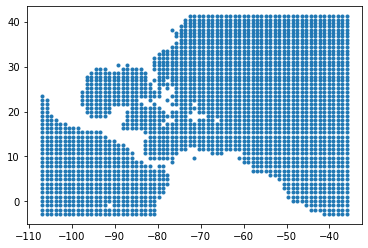

In [43]:
# load data from last run and check density within tile
tile = 23
# init_file = self.nc(step=0)
init_file = "/home1/scratch/aponte/parcels/debug/run/data_023/floats_000_023.nc"
ds_init = xr.open_dataset(init_file).isel(obs=0)
plt.plot(ds_init.lon, ds_init.lat, '.')
lon_init, lat_init = ds_init.lon.values, ds_init.lat.values

In [33]:
from mitequinox.drifters import haversine
from heapq import nsmallest

In [37]:
%time
#separation_init = [min(haversine(lon, lat, lon_init, lat_init)) for lon, lat in zip(lon_init, lat_init)]
separation_init = [nsmallest(2, haversine(lon, lat, lon_init, lat_init))[1] 
                   for lon, lat in zip(lon_init, lat_init)
                  ]
separation_init[0] # in km

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


107.47577034216799

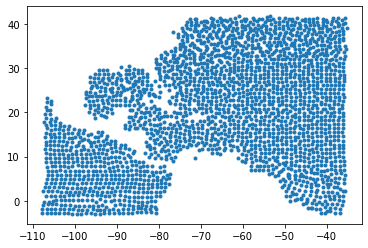

In [42]:
# load last positions
last_file = "/home1/scratch/aponte/parcels/debug/run/data_023/floats_001_023.nc"
ds_last = xr.open_dataset(last_file).isel(obs=-2)
lon_last, lat_last = ds_last.lon.values, ds_last.lat.values
plt.plot(lon_last, lat_last, '.')

In [56]:
separation_now = [nsmallest(2, haversine(lon, lat, lon_last, lat_last))[1] 
                   for lon, lat in zip(lon_init, lat_init)
                  ]

boolean_now = [min(haversine(lon, lat, lon_last, lat_last))>s_init
                   for lon, lat, s_init in zip(lon_init, lat_init, separation_init)
                  ]

In [58]:
[(lon, lat) for lon, lat, s_init in zip(lon_init, lat_init, separation_init) if min(haversine(lon, lat, lon_last, lat_last))>s_init]

[]

In [61]:
a, b = list(zip(*[(1, 2), (3, 4), (5, 6)]))

In [63]:
b

(2, 4, 6)

In [50]:
#list(zip(separation_init, separation_now))

In [46]:
boolean_now

[False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fal

In [39]:
ds_last

<xarray.Dataset>
Dimensions:      (traj: 2464)
Dimensions without coordinates: traj
Data variables:
    trajectory   (traj) float64 ...
    time         (traj) datetime64[ns] ...
    lat          (traj) float64 ...
    lon          (traj) float64 ...
    z            (traj) float64 ...
    sea_level    (traj) float32 ...
    temperature  (traj) float32 ...
    salinity     (traj) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.2
    parcels_mesh:           spherical

-106.86458587646484 -2.7742722034454346
-106.86458587646484 -1.8087801933288574
-106.86458587646484 -0.8419859409332275
-106.86458587646484 0.1258590966463089
-106.86458587646484 1.0934644937515259
-106.86458587646484 2.0599429607391357
-106.86458587646484 3.025057792663574
-106.86458587646484 3.9885735511779785
-106.86458587646484 4.950256824493408
-106.86458587646484 5.909876346588135
-106.86458587646484 6.867203235626221
-106.86458587646484 7.822010517120361
-106.86458587646484 8.774075508117676
-106.86458587646484 9.723176956176758
-106.86458587646484 10.669099807739258
-106.86458587646484 11.611629486083984
-106.86458587646484 12.550559043884277
-106.86458587646484 13.485682487487793
-106.86458587646484 14.416800498962402
-106.86458587646484 15.343717575073242
-106.86458587646484 16.26624298095703
-106.86458587646484 17.184192657470703
-106.86458587646484 18.09738540649414
-106.86458587646484 19.005647659301758
-106.86458587646484 19.908811569213867
-106.86458587646484 20.80670928

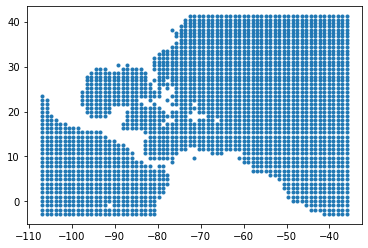

In [26]:
# initial separations
for lon, lat, s in zip(lon_init, lat_init, s):
    print(lon,lat)
    print()

In [24]:
dij

NameError: name 'dij' is not defined

In [23]:
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(88,), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YC       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    XG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    YG       (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    CS       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Depth    (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SN       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxC      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dxG      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyC      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    dyG      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rA       (face, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAs      (face, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAw      (face, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    rAz      (face, j_g, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
Data variables:
    SSU      (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSV      (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    Eta      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SST      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    SSS      (time, face, j, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [12]:
tl

In [11]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


In [ ]:
# debug

In [ ]:
%%time

t_start = ut.np64toDate(ds['time'][0].values)
dt_window = timedelta(days=1.) 
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)

t_end = t_start + 10*dt_window
#t_end = t_start + 365*dt_window

print('begin =',t_start.strftime("%Y-%m-%d:%H"))
print('end=',t_end.strftime("%Y-%m-%d:%H"))  

#step = 0
#t = t_start
for step, t in enumerate(ut.dateRange(t_start, t_end, dt_window)):

    endtime = t+dt_window+dt_step
    print('-------------------------------------------')
    print('step=', step)
    print('start=', t.strftime("%Y-%m-%d:%H"))
    print('end=', endtime.strftime("%Y-%m-%d:%H")) 

    # load, tile (and store) llc data
    ds_tiles = pa.tile_store_llc(ds,
                                 slice(t, endtime, None),
                                 tl,
                                 netcdf=False,
                                )

    #if step > 1000 :
    if single :
        # looks like a hack to run without dask: sylvie confirms?
        #for tile in range(tl.N_tiles):
        tile = 23
        tmp = pa.step_window(tile, step, t, endtime, 
                             dt_window, dt_step, dt_outputs, 
                             tl,
                             ds_tile=ds_tiles[tile], init_dij=init_dij, 
                                  parcels_remove_on_land=True,
                                 ) 
    else:
        dsteps = [delayed(pa.step_window)(tile, step, t, endtime,
                                 dt_window, dt_step, dt_outputs, 
                                          tl,
                                          ds_tile=ds_tiles[tile], init_dij=init_dij, 
                                          parcels_remove_on_land=True,
                                         ) 
                  for tile in range(tl.N_tiles)
                 ]
        dsteps_out = dask.compute(*dsteps)

In [ ]:
%%time

t_start = ut.np64toDate(ds['time'][0].values)
dt_window = timedelta(days=1.) 
dt_outputs = timedelta(hours=1.)
dt_step = timedelta(hours=1.)

t_end = t_start + 10*dt_window
#t_end = t_start + 365*dt_window

print('begin =',t_start.strftime("%Y-%m-%d:%H"))
print('end=',t_end.strftime("%Y-%m-%d:%H"))  

#step = 0
#t = t_start
#for step, t in enumerate(np.arange(t_restart, T, dt_window)):
for step, t in enumerate(ut.dateRange(t_start, t_end, dt_window)):

    endtime = t+dt_window+dt_step
    print('-------------------------------------------')
    print('step=', step)
    print('start=', t.strftime("%Y-%m-%d:%H"))
    print('end=', endtime.strftime("%Y-%m-%d:%H")) 

    # load, tile (and store) llc data
    ds_tiles = pa.tile_store_llc(ds,
                                 slice(t, endtime, None),
                                 tl,
                                 netcdf=False,
                                )

    if step > 0 :
        if single :
            # looks like a hack to run without dask: sylvie confirms?
            #for tile in range(tl.N_tiles):
            tile = 23
            db = pa.step_window(tile, step, t, endtime, 
                                 dt_window, dt_step, dt_outputs, 
                                 tl,
                                 ds_tile=ds_tiles[tile], init_dij=init_dij, 
                                      parcels_remove_on_land=True,
                                  verbose=1,
                                    )
            break
        else:
            dsteps = [delayed(pa.step_window)(tile, step, t, endtime,
                                     dt_window, dt_step, dt_outputs, 
                                              tl,
                                              ds_tile=ds_tiles[tile], init_dij=init_dij, 
                                              parcels_remove_on_land=True,
                                             ) 
                      for tile in range(tl.N_tiles)
                     ]
            dsteps_out = dask.compute(*dsteps) 


---
## Load netcdf file and store in parquet format
faster to reload from the netcdf files with right index than to change index of the dask dataframe

### save with time index

In [ ]:
%%time
df = pa.load_cdf(run_dir, index='time')
pa.store_parquet(run_dir, df, index='time', overwrite=True)

### save with trajectory id index

In [ ]:
%%time
df = pa.load_cdf(run_dir, index='trajectory')
pa.store_parquet(run_dir, df, index='trajectory', overwrite=True)

### save with H3 geographic index

In [ ]:
%%time
df = pa.load_cdf(run_dir, index='trajectory')
df = pa.h3_index(df)
pa.store_parquet(run_dir, df, index='hex_id', overwrite=True)

## Close cluster

In [ ]:
cluster.close()